In [285]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jinja2
from dataprep.eda import create_report, plot, plot_correlation, plot_missing , plot_diff
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, accuracy_score
import plotly.express as px

from lightgbm import LGBMClassifier, log_evaluation, LGBMRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from optuna.integration import CatBoostPruningCallback
from sklearn.base import BaseEstimator, TransformerMixin

import lightgbm as lgbm
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
import optuna
import numpy as np

In [286]:
df = pd.read_csv('train.csv')
og = pd.read_csv('original.csv')
test_df = pd.read_csv('test.csv')
df.shape, og.shape

((414, 8), (79, 7))

In [287]:
df.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [288]:
df.isnull().values.any(), og.isnull().values.any()

(False, False)

In [289]:
df.drop('id',axis=1, inplace=True)
test_df.drop('id',axis=1, inplace=True)

In [290]:
# df = pd.concat([df,og],ignore_index=True)
# df.shape

In [291]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gravity,414.0,1.017894,0.006675,1.005,1.012,1.018,1.022,1.04
ph,414.0,5.955459,0.642260,4.760,5.530,5.740,6.280,7.94
osmo,414.0,651.545894,234.676567,187.000,455.250,679.500,840.000,1236.00
cond,414.0,21.437923,7.514750,5.100,15.500,22.200,27.600,38.00
urea,414.0,278.657005,136.442249,10.000,170.000,277.000,385.000,620.00
calc,414.0,4.114638,3.217641,0.170,1.450,3.130,6.630,14.34
target,414.0,0.444444,0.497505,0.000,0.000,0.000,1.000,1.00


In [292]:
# def outlier_removal(data , i):
#     q1 = np.quantile(data[i] ,0.25)
#     q3 = np.quantile(data[i] , 0.75)
#     iqr = q3-q1
#     lower_tail = q1 - 1.5*iqr
#     upper_tail = q3 + 1.5*iqr
#     data.drop(data[data[i]> upper_tail].index , inplace = True)
#     data.drop(data[data[i]< lower_tail].index ,inplace =True)
    
# outlier_list = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
# for  i in outlier_list:
#     outlier_removal(df ,i)
# print(df.shape)

In [293]:
# new feats
def new_feats(feat):
    feat_copy = feat.copy()
    feat_copy['Urine_Dilution'] = feat_copy['gravity'] / feat_copy['ph']
    # feat_copy['AcidBase'] = feat_copy['ph'].apply(lambda x: 1 if x < 5 else 0)
    feat_copy['UreaAdjusted'] = feat_copy['urea'] / feat_copy['gravity']
    # feat_copy["ion_product"] = feat_copy["calc"] * feat_copy["urea"]
    # feat_copy["calcium_to_urea_ratio"] = feat_copy["calc"] / feat_copy["urea"]
    # feat_copy["electrolyte_balance"] = feat_copy["cond"] / (10 ** (-feat_copy["ph"]))
    # feat_copy["osmolality_to_sg_ratio"] = feat_copy["osmo"] / feat_copy["gravity"]
    # feat_copy['osmo_density'] = feat_copy['osmo'] * feat_copy['gravity']
    
    # # ******************************************************************
    feat_copy["sum"] = feat_copy['calc']+feat_copy['gravity']-8.20807805874e-3*feat_copy['cond']
    # # # Calculate ammonium concentration (assuming ammonium is not directly measured)
    # feat_copy['ammonium_concentration'] = (feat_copy['gravity'] - 1.010) * (140 - (2 * feat_copy["ph"])) * 1.2
    # # # Calculate phosphate concentration (assuming phosphate is not directly measured)
    # feat_copy['phosphate_concentration'] = (feat_copy['gravity'] - 1.010) * (32 - (0.06 * feat_copy["ph"]))

    # # *****************************************************************
    
    # feat_copy["gravity/ph"] = feat_copy["gravity"] / feat_copy["ph"]
    # feat_copy["osmo/cond"] = feat_copy["osmo"] / feat_copy["cond"]
    # feat_copy["gravity*ph"] = feat_copy["gravity"] * feat_copy["ph"]
    # feat_copy["osmo*urea"] = feat_copy["osmo"] * feat_copy["urea"]
    # feat_copy["cond_urea_ph"] = feat_copy["cond"] * feat_copy["urea"] / feat_copy["ph"]
    # feat_copy["ph*osmo"] = feat_copy["ph"] * feat_copy["osmo"]
    # feat_copy["cond*calc"] = feat_copy["cond"] * feat_copy["calc"]
    # feat_copy["gravity/calc"] = feat_copy["gravity"] / feat_copy["calc"]
    return feat_copy

df_feats = new_feats(df)
test_df = new_feats(test_df)
df.shape, df_feats.shape

((414, 7), (414, 10))

In [294]:
features = [f for f in df_feats.columns if f!= 'target']
features

['gravity',
 'ph',
 'osmo',
 'cond',
 'urea',
 'calc',
 'Urine_Dilution',
 'UreaAdjusted',
 'sum']

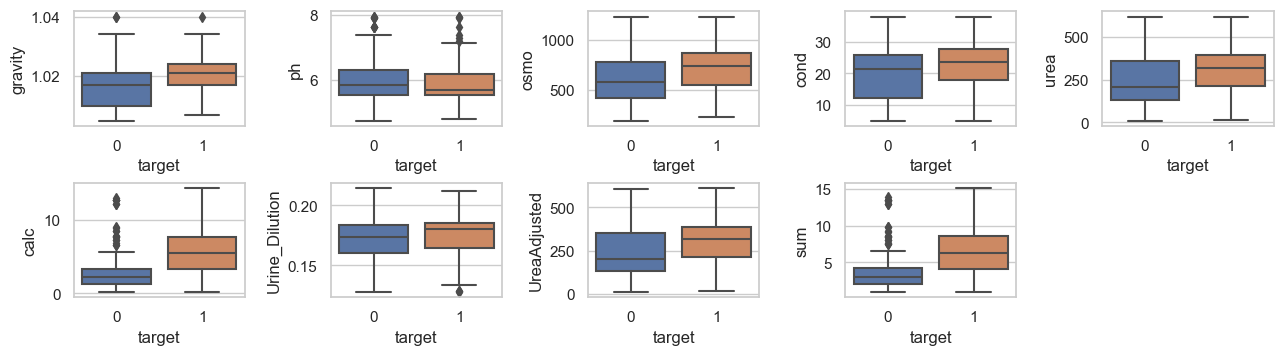

In [295]:
# Set the figure size
plt.figure(figsize=(15, 10))
sns.set_theme(style="whitegrid")
# Create categorical features subplots
for i, feature in enumerate(features):
    ax = plt.subplot(5, 5, i+1)
    sns.boxplot(x="target", y=feature , data=df_feats, ax=ax)
    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=.5, wspace=0.5)

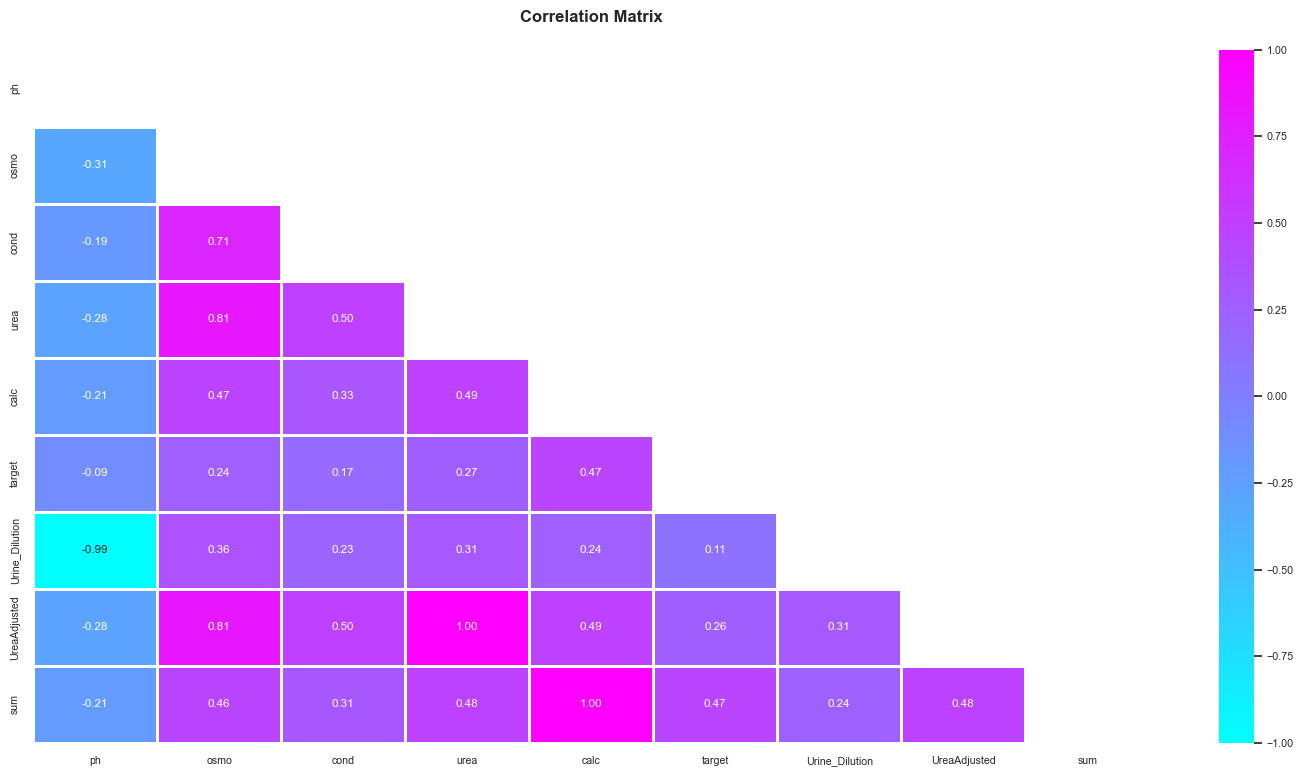

In [296]:
corr = df_feats.iloc[:,1:].corr()

# create mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create heatmap
plt.figure(figsize=(18, 9))
# set theme to change overall style
sns.set_theme(style="white", font_scale=0.7)
sns.heatmap(corr, cmap="cool", linewidths=2, mask=mask, vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Correlation Matrix", fontsize=12, weight = 'bold', pad=20)
plt.show()

In [297]:
df_feats.isnull().sum()

gravity           0
ph                0
osmo              0
cond              0
urea              0
calc              0
target            0
Urine_Dilution    0
UreaAdjusted      0
sum               0
dtype: int64

ph is not outlier!!

Modelling

In [298]:
X = df_feats.drop('target',axis=1)
y = df_feats.target

X.shape, y.shape

((414, 9), (414,))

In [299]:
scaler = StandardScaler()
cols = X.columns
X = scaler.fit_transform(X)
X = pd.DataFrame(X,columns=cols)
X.describe().T

,count,mean,std,min,25%,50%,75%,max
gravity,414.0,3.259658e-14,1.00121,-1.933988,-0.884026,0.015941,0.615920,3.315823
ph,414.0,-1.244308e-16,1.00121,-1.863584,-0.663242,-0.335876,0.505922,3.093672
osmo,414.0,2.102451e-16,1.00121,-1.981911,-0.837465,0.119262,0.804009,2.493480
cond,414.0,1.566112e-16,1.00121,-2.176745,-0.791125,0.101534,0.820990,2.206609
urea,414.0,1.287215e-16,1.00121,-1.971399,-0.797322,-0.012159,0.780342,2.504767
calc,414.0,-6.865147e-17,1.00121,-1.227424,-0.829136,-0.306383,0.782687,3.181752
Urine_Dilution,414.0,-1.201401e-16,1.00121,-2.540957,-0.593875,0.264887,0.670762,2.351968
UreaAdjusted,414.0,-1.544658e-16,1.00121,-1.985561,-0.801613,-0.015529,0.774589,2.554023
sum,414.0,-7.294219e-17,1.00121,-1.247111,-0.838638,-0.313216,0.787345,3.188504


In [300]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, stratify=y, random_state=123,test_size=0.2)
X_train.shape, X_test.shape

((331, 9), (83, 9))

In [301]:
smote = SMOTE()
X_train_smote , y_train_smote = smote.fit_resample(X_train,y_train)

In [302]:
clf = RandomForestClassifier(random_state=12,class_weight='balanced')
clf.fit(X_train,y_train)

y_pred = clf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'clf score: {clf.score(X_test,y_test)}, AUC: {auc}')

clf score: 0.7710843373493976, AUC: 0.8510575793184489


In [303]:
# get feature importances
importances = clf.feature_importances_

# create feature importance dataframe
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})

# sort by importance descending
feat_imp = feat_imp.sort_values('importance', ascending=False)

# create bar chart with color gradient
fig = px.bar(feat_imp, x='feature', y='importance', color='importance', color_continuous_scale='Blues')

fig.show()

In [304]:
log = LogisticRegression(random_state=12)
log.fit(X_train_smote,y_train_smote)

y_pred = log.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'log score: {log.score(X_test,y_test)}, AUC: {auc}')

log score: 0.8192771084337349, AUC: 0.8225616921269095


In [305]:
lgb = LGBMClassifier(random_state=12, class_weight='balanced',objective='binary')
lgb.fit(X_train,y_train, eval_set=(X_test,y_test),callbacks=[log_evaluation(100)])
y_pred = lgb.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'lgb score: {lgb.score(X_test,y_test)}, AUC: {auc}')

[100]	valid_0's binary_logloss: 0.572863
lgb score: 0.7469879518072289, AUC: 0.8378378378378378


In [306]:
xgb = XGBClassifier(random_state=12, eval_metric='auc')
xgb.fit(X_train,y_train)
y_pred = xgb.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'xgb score: {xgb.score(X_test,y_test)}, AUC: {auc}')

xgb score: 0.7469879518072289, AUC: 0.8331374853113984


In [307]:
cat_class = CatBoostClassifier(random_state=12, eval_metric='AUC',early_stopping_rounds=100,verbose=False, use_best_model=True)
cat_class.fit(X_train_smote,y_train_smote, eval_set=(X_test,y_test))
y_pred = cat_class.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'cat_class score: {cat_class.score(X_test,y_test)}, AUC: {auc}')

cat_class score: 0.7951807228915663, AUC: 0.8487074030552292


Hyperparameter RandomForest TUning XGB, CAT, LGBM

In [308]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def objective(trial: optuna.Trial) -> float:

    params = {
            'criterion': trial.suggest_categorical('criterion',['gini','entropy','log_loss']),
            'n_estimators': trial.suggest_int('n_estimators', 50, 3000),
            'max_depth': trial.suggest_int('max_depth', 4, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 3, 150),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 60),
            'max_features': trial.suggest_categorical('max_features',['sqrt', 'log2', None]),
            'bootstrap': True
        }

    gbm = RandomForestClassifier(**params, random_state=43)

    # smote = SMOTE()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)   
    i=0
    cv_scores = []
    for train_index, valid_index in skf.split(X, y):
        train_x, train_y = X.iloc[train_index], y[train_index]
        valid_x, valid_y = X.iloc[valid_index], y[valid_index]
        # train_x , train_y = smote.fit_resample(train_x,train_y)
        # categorical_features_indices = np.where((train_x.dtypes == object).values.astype(int) == 1)[0]


        gbm.fit(
            train_x,
            train_y
        )

        preds = gbm.predict_proba(valid_x)[:,1]
        rocauc = roc_auc_score(valid_y,preds)
        cv_scores.append(rocauc)
        # i+=1
        # print(f"fold {i} logloss: {logloss}, Accuracy: {accuracy}")
    return np.mean(cv_scores)


if __name__ == "__main__":
    study = optuna.create_study(study_name='RandomForestClassifier',
        pruner=optuna.pruners.MedianPruner(n_startup_trials=3), direction="maximize",)
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-04-18 01:45:39,759] A new study created in memory with name: RandomForestClassifier
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-04-18 01:45:45,951] Trial 0 finished with value: 0.7848903251077164 and parameters: {'criterion': 'log_loss', 'n_estimators': 1740, 'max_depth': 24, 'min_samples_split': 87, 'min_samples_leaf': 54, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7848903251077164.
[I 2023-04-18 01:45:50,364] Trial 1 finished with value: 0.7963898681289986 and parameters: {'criterion': 'gini', 'n_estimators': 1109, 'max_depth': 13, 'min_samples_split': 85, 'min_samples_leaf': 40, 'max_features': None}. Best is trial 1 with value: 0.7963898681289986.
[I 2023-04-18 01:45:50,767] Trial 2 finished with value: 0.7799125212168689 and parameters: {'criterion': 'gini', 'n_estimators': 113, 'max_depth': 9, 'min_samples_split': 141, 'min_samples_leaf': 34, 'max_features': 'log2'}. Best is trial 1 with value: 0.7963898681289986.


In [51]:
study.best_params

{'criterion': 'gini',
 'n_estimators': 1726,
 'max_depth': 50,
 'min_samples_split': 93,
 'min_samples_leaf': 8,
 'max_features': None}

In [65]:
# rf_params = {'criterion': 'gini',
#  'n_estimators': 1726,
#  'max_depth': 50,
#  'min_samples_split': 93,
#  'min_samples_leaf': 8,
#  'max_features': None}

# only train
rf_params = {'criterion': 'entropy',
 'n_estimators': 519,
 'max_depth': 17,
 'min_samples_split': 126,
 'min_samples_leaf': 36,
 'max_features': None}

In [66]:
clf_tune = RandomForestClassifier(random_state=0,**rf_params)
clf_tune.fit(X_train,y_train)

y_pred = clf_tune.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'clf_tune score: {clf_tune.score(X_test,y_test)}, AUC: {auc}')

clf_tune score: 0.7272727272727273, AUC: 0.7869834710743802


In [67]:
import warnings
warnings.filterwarnings(category=UserWarning,action='ignore')
warnings.filterwarnings('ignore', category=UserWarning, message='.*experimental.*')

def objective(trial):
    params = {
        'objective':'binary',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart']),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.4),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample_freq': trial.suggest_int('bagging_freq', 1, 10),
        'metric':'auc'
        
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Apply SMOTE oversampling to X_train and y_train
        # smote = SMOTE()
        # X_train, y_train = smote.fit_resample(X_train, y_train)

        model = lgbm.LGBMClassifier(**params,random_state=12)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=100,
            verbose=False,
            callbacks=[LightGBMPruningCallback(trial, 'auc')]
        )
        preds = model.predict_proba(X_test)[:, 1]
        cv_scores[idx] = roc_auc_score(y_test, preds)

    return np.mean(cv_scores)

In [68]:
study = optuna.create_study(direction='maximize', study_name="LGBMClassifier", pruner=optuna.pruners.MedianPruner(n_startup_trials=10,n_warmup_steps=50))
study.optimize(objective, n_trials=500, show_progress_bar=True)

[I 2023-04-17 23:29:30,210] A new study created in memory with name: LGBMClassifier
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/500 [00:00<?, ?it/s]

[I 2023-04-17 23:29:36,788] Trial 0 finished with value: 0.5558177974245627 and parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'max_depth': 6, 'learning_rate': 0.013096686477247186, 'n_estimators': 1074, 'subsample': 0.3338414821131683, 'colsample_bytree': 0.33180603875738335, 'reg_alpha': 9.6694472969233, 'reg_lambda': 7.180544706289398, 'min_child_samples': 75, 'bagging_freq': 8}. Best is trial 0 with value: 0.5558177974245627.
[I 2023-04-17 23:29:37,345] Trial 1 finished with value: 0.779349413799731 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 71, 'max_depth': 4, 'learning_rate': 0.06797670441597527, 'n_estimators': 1769, 'subsample': 0.44158371671480834, 'colsample_bytree': 0.5793445877587556, 'reg_alpha': 8.131180903892853, 'reg_lambda': 4.75160183407093, 'min_child_samples': 87, 'bagging_freq': 10}. Best is trial 1 with value: 0.779349413799731.
[I 2023-04-17 23:29:43,094] Trial 2 finished with value: 0.5 and parameters: {'boosting_type': 'dart', 'num_leaves'

In [69]:
print(f"\tBest value (rocauc): {study.best_value:.5f}")
print(f"\tBest params:")
print(study.best_params)

	Best value (rocauc): 0.84326
	Best params:
{'boosting_type': 'gbdt', 'num_leaves': 71, 'max_depth': 10, 'learning_rate': 0.34010477573600073, 'n_estimators': 492, 'subsample': 0.697480623357571, 'colsample_bytree': 0.25888611796340116, 'reg_alpha': 2.156656841972668, 'reg_lambda': 4.964260499545862, 'min_child_samples': 13, 'bagging_freq': 6}


In [72]:
lgb_params = {'boosting_type': 'gbdt', 'num_leaves': 71, 'max_depth': 10, 'learning_rate': 0.34010477573600073, 'n_estimators': 492, 'subsample': 0.697480623357571, 'colsample_bytree': 0.25888611796340116, 'reg_alpha': 2.156656841972668, 'reg_lambda': 4.964260499545862, 'min_child_samples': 13, 'bagging_freq': 6}



In [73]:
lgb_tune = LGBMClassifier(random_state=12, **lgb_params)
lgb_tune.fit(X_train,y_train, eval_set=(X_test,y_test),callbacks=[log_evaluation(1000)])
y_pred = lgb_tune.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'lgb_tune score: {lgb_tune.score(X_test,y_test)}, AUC: {auc}')

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
lgb_tune score: 0.6868686868686869, AUC: 0.784710743801653


In [91]:
import xgboost as xgb
from optuna.integration import XGBoostPruningCallback
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
import optuna
import numpy as np

def objective(trial):
    params = {
        'eval_metric': 'auc',
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'eta': trial.suggest_float('eta', 1e-5, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.001, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
        #  only for imbalance
        # 'max_delta_step': trial.suggest_categorical('max_delta_step',[0,5,10,30,30,40,50]) 
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)
    model = xgb.XGBClassifier(**params,random_state=43)
    cv_scores = np.empty(5)
    i=0
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Apply SMOTE oversampling to X_train and y_train
        # smote = SMOTE()
        # X_train, y_train = smote.fit_resample(X_train, y_train)

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = model.predict_proba(X_test)[:, 1]
        rocauc = roc_auc_score(y_test,preds)
        cv_scores[idx] = rocauc
    return np.mean(cv_scores)

In [96]:
study = optuna.create_study(direction='maximize', study_name='XGB_classifier')
study.optimize(objective, n_trials=700, show_progress_bar=True)
print(study.best_params)

[I 2023-04-17 23:51:49,785] A new study created in memory with name: XGB_classifier
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/700 [00:00<?, ?it/s]

[I 2023-04-17 23:51:50,036] Trial 0 finished with value: 0.7672016144532 and parameters: {'max_depth': 13, 'eta': 0.5427320423178356, 'min_child_weight': 2, 'gamma': 0.09230470548144082, 'subsample': 0.10098205850801817, 'colsample_bytree': 0.9507167011765042, 'reg_alpha': 1.953492326993493, 'reg_lambda': 1.639287180550119}. Best is trial 0 with value: 0.7672016144532.
[I 2023-04-17 23:51:50,221] Trial 1 finished with value: 0.8013127042091102 and parameters: {'max_depth': 1, 'eta': 0.20348017042917194, 'min_child_weight': 2, 'gamma': 0.06684597309849664, 'subsample': 0.3509252116064874, 'colsample_bytree': 0.3035688671852491, 'reg_alpha': 4.51230358701348, 'reg_lambda': 7.829303933928239}. Best is trial 1 with value: 0.8013127042091102.
[I 2023-04-17 23:51:50,451] Trial 2 finished with value: 0.8228570055737074 and parameters: {'max_depth': 13, 'eta': 0.5763137470437673, 'min_child_weight': 2, 'gamma': 0.11531133054095222, 'subsample': 0.7552938226516482, 'colsample_bytree': 0.5182376

In [98]:
study.best_params

{'max_depth': 11,
 'eta': 0.7145234147504963,
 'min_child_weight': 3,
 'gamma': 0.04054869414461025,
 'subsample': 0.9014766679151861,
 'colsample_bytree': 0.028624505374613744,
 'reg_alpha': 4.017663774234554,
 'reg_lambda': 1.3907538025971735}

In [101]:

xgb_params = {'max_depth': 11,
 'eta': 0.10288325096223679,
 'min_child_weight': 3,
 'gamma': 0.042977474200641,
 'subsample': 0.7888537294776343,
 'colsample_bytree': 0.5732487688037096,
 'reg_alpha': 1.5500257999897522,
 'reg_lambda': 7.184563346426339}


# only train data no og
# xgb_params = {
#     'max_depth': 8,
#     'eta': 0.16305044455164977,
#     'min_child_weight': 18,
#     'gamma': 0.11712334392622112,
#     'subsample': 0.9920485127038325,
#     'colsample_bytree': 0.765250387587039,
#     'reg_alpha': 0.008788883682020746,
#     'reg_lambda': 0.018141543669711144
#     }

# xgb_params = {'max_depth': 1,
#  'eta': 0.11714605952941523,
#  'min_child_weight': 2,
#  'gamma': 0.2610698252586401,
#  'subsample': 0.5869827322228711,
#  'colsample_bytree': 0.7170351315920238,
#  'reg_alpha': 0.5785016043684591,
#  'reg_lambda': 0.06584531912227781}


In [102]:
xgb_tune = XGBClassifier(random_state=43, eval_metric='auc',**xgb_params)
xgb_tune.fit(X_train,y_train)
y_pred = xgb_tune.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'xgb_tune score: {xgb_tune.score(X_test,y_test)}, AUC: {auc}')

xgb_tune score: 0.7171717171717171, AUC: 0.7946280991735537


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', category=UserWarning, message='.*experimental.*')


def objective(trial: optuna.Trial) -> float:
    data, target = X,y
    # train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 1),
        "iterations": trial.suggest_int('iterations',400,1000),
        "random_strength": trial.suggest_float("random_strength", 0.001, 10, log=True),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "AUC",
        'random_seed': 123,
        
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = CatBoostClassifier(**param, use_best_model=True)

    pruning_callback = CatBoostPruningCallback(trial, "AUC")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)   

    cv_scores = []
    for train_index, valid_index in skf.split(X, y):
        train_x, train_y = X.iloc[train_index], y[train_index]
        valid_x, valid_y = X.iloc[valid_index], y[valid_index]
        train_x , train_y = smote.fit_resample(train_x,train_y)
        # categorical_features_indices = np.where((train_x.dtypes == object).values.astype(int) == 1)[0]


        gbm.fit(
            train_x,
            train_y,
            eval_set=[(valid_x, valid_y)],
            verbose=0,
            early_stopping_rounds=100,
            callbacks=[pruning_callback],
        )

        # evoke pruning manually.
        pruning_callback.check_pruned()

        preds = gbm.predict(valid_x)
        pred_proba = gbm.predict_proba(valid_x)[:,1]
        rocauc = roc_auc_score(valid_y,pred_proba)
        cv_scores.append(rocauc)
    return np.mean(cv_scores)


if __name__ == "__main__":
    study = optuna.create_study(study_name='CatClassifier',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=50, n_startup_trials=3), direction="maximize",
        load_if_exists=True
    )
    study.optimize(objective, n_trials=2000,timeout=300, show_progress_bar=True)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [125]:
study.best_params

{'objective': 'Logloss',
 'learning_rate': 0.554864229676231,
 'iterations': 500,
 'random_strength': 0.0030029558035803683,
 'colsample_bylevel': 0.07737227002881103,
 'depth': 8,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.1695726075477245}

In [137]:
cb_params = {'objective': 'Logloss',
 'learning_rate': 0.554864229676231,
 'iterations': 500,
 'random_strength': 0.0030029558035803683,
 'colsample_bylevel': 0.07737227002881103,
 'depth': 8,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.1695726075477245}

In [138]:
cat_tune = CatBoostClassifier(early_stopping_rounds=100,verbose=False, use_best_model=True,**cb_params)
cat_tune.fit(X_train,y_train, eval_set=(X_test,y_test))
y_pred = cat_tune.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f'cat_tune score: {cat_tune.score(X_test,y_test)}, AUC: {auc}')

cat_tune score: 0.7676767676767676, AUC: 0.8115702479338843


Regressors

In [139]:
clf = RandomForestRegressor(random_state=12)
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'clf score: {clf.score(X_test,y_test)}, AUC: {auc}')

clf score: 0.11154045454545491, AUC: 0.7524793388429752


In [140]:
# get feature importances
importances = clf.feature_importances_

# create feature importance dataframe
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})

# sort by importance descending
feat_imp = feat_imp.sort_values('importance', ascending=False)

# create bar chart with color gradient
fig = px.bar(feat_imp, x='feature', y='importance', color='importance', color_continuous_scale='Blues')

fig.show()

In [141]:
lgb = LGBMRegressor(random_state=12,objective='RMSE')
lgb.fit(X_train,y_train, eval_set=(X_test,y_test),callbacks=[log_evaluation(100)])
y_pred = lgb.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'lgb score: {lgb.score(X_test,y_test)}, AUC: {auc}')

[100]	valid_0's rmse: 0.459877
lgb score: 0.14347678528892782, AUC: 0.7756198347107438


In [142]:
xgb = XGBRegressor(random_state=12, eval_metric='rmse')
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'xgb score: {xgb.score(X_test,y_test)}, AUC: {auc}')

xgb score: -0.0031102479902918034, AUC: 0.7392561983471075


In [143]:
cat = CatBoostRegressor(random_state=12, eval_metric='RMSE',early_stopping_rounds=100,verbose=False, use_best_model=True)
cat.fit(X_train_smote,y_train_smote, eval_set=(X_test,y_test))
y_pred = cat.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'cat score: {cat.score(X_test,y_test)}, AUC: {auc}')

cat score: 0.23788079301663612, AUC: 0.793801652892562


In [146]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def objective(trial: optuna.Trial) -> float:

    params = {
            'criterion': trial.suggest_categorical('criterion',['squared_error']),
            'n_estimators': trial.suggest_int('n_estimators', 50, 3000),
            'max_depth': trial.suggest_int('max_depth', 4, 50),
            'min_samples_split': trial.suggest_int('min_samples_split', 3, 150),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 60),
            'max_features': trial.suggest_categorical('max_features',['sqrt', 'log2', None]),
            'bootstrap': True
        }

    gbm = RandomForestRegressor(**params, random_state=43)

    # smote = SMOTE()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)   
    i=0
    cv_scores = []
    for train_index, valid_index in skf.split(X, y):
        train_x, train_y = X.iloc[train_index], y[train_index]
        valid_x, valid_y = X.iloc[valid_index], y[valid_index]
        # train_x , train_y = smote.fit_resample(train_x,train_y)
        # categorical_features_indices = np.where((train_x.dtypes == object).values.astype(int) == 1)[0]


        gbm.fit(
            train_x,
            train_y
        )

        preds = gbm.predict(valid_x)
        rocauc = roc_auc_score(valid_y,preds)
        cv_scores.append(rocauc)
        # i+=1
        # print(f"fold {i} logloss: {logloss}, Accuracy: {accuracy}")
    return np.mean(cv_scores)


if __name__ == "__main__":
    study = optuna.create_study(study_name='RandomForestRegressor',
        pruner=optuna.pruners.MedianPruner(n_startup_trials=3), direction="maximize",)
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-04-18 00:16:58,988] A new study created in memory with name: RandomForestRegressor
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-04-18 00:17:02,094] Trial 0 finished with value: 0.8025696713434556 and parameters: {'criterion': 'squared_error', 'n_estimators': 877, 'max_depth': 44, 'min_samples_split': 22, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 0 with value: 0.8025696713434556.
[I 2023-04-18 00:17:03,888] Trial 1 finished with value: 0.7971506822986738 and parameters: {'criterion': 'squared_error', 'n_estimators': 587, 'max_depth': 41, 'min_samples_split': 88, 'min_samples_leaf': 50, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8025696713434556.
[I 2023-04-18 00:17:11,033] Trial 2 finished with value: 0.8048846819142803 and parameters: {'criterion': 'squared_error', 'n_estimators': 2138, 'max_depth': 32, 'min_samples_split': 131, 'min_samples_leaf': 20, 'max_features': None}. Best is trial 2 with value: 0.8048846819142803.
[I 2023-04-18 00:17:18,151] Trial 3 finished with value: 0.800737074764559 and parameters: {'criterion': 'squared_error', 'n_estimators': 1980, 'max_de

In [147]:
study.best_params

{'criterion': 'squared_error',
 'n_estimators': 304,
 'max_depth': 28,
 'min_samples_split': 84,
 'min_samples_leaf': 8,
 'max_features': None}

In [150]:
# only train
rf_params_reg = {'criterion': 'squared_error',
 'n_estimators': 304,
 'max_depth': 28,
 'min_samples_split': 84,
 'min_samples_leaf': 8,
 'max_features': None}

In [151]:
clf_tune_reg = RandomForestRegressor(random_state=43,**rf_params_reg)
clf_tune_reg.fit(X_train,y_train)

y_pred = clf_tune_reg.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'clf_tune_reg score: {clf_tune_reg.score(X_test,y_test)}, AUC: {auc}')

clf_tune_reg score: 0.19760119856933023, AUC: 0.7797520661157025


In [154]:
import warnings
warnings.filterwarnings(category=UserWarning,action='ignore')
warnings.filterwarnings('ignore', category=UserWarning, message='.*experimental.*')

def objective(trial):
    params = {
        'objective':'rmse',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart']),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.4),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample_freq': trial.suggest_int('bagging_freq', 1, 10),
        'metric':'auc'
        
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Apply SMOTE oversampling to X_train and y_train
        # smote = SMOTE()
        # X_train, y_train = smote.fit_resample(X_train, y_train)

        model = lgbm.LGBMRegressor(**params,random_state=12)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            early_stopping_rounds=100,
            verbose=False,
            callbacks=[LightGBMPruningCallback(trial, 'auc')]
        )
        preds = model.predict(X_test)
        cv_scores[idx] = roc_auc_score(y_test, preds)

    return np.mean(cv_scores)

In [155]:
study = optuna.create_study(direction='maximize', study_name="LGBMRegressor", pruner=optuna.pruners.MedianPruner(n_startup_trials=10,n_warmup_steps=50))
study.optimize(objective, n_trials=500, show_progress_bar=True)

[I 2023-04-18 00:21:37,726] A new study created in memory with name: LGBMRegressor
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/500 [00:00<?, ?it/s]

[I 2023-04-18 00:21:51,138] Trial 0 finished with value: 0.5076619258120315 and parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'max_depth': 11, 'learning_rate': 0.2556553178147046, 'n_estimators': 1463, 'subsample': 0.8057109931125366, 'colsample_bytree': 0.8346108017396057, 'reg_alpha': 8.960747361455816, 'reg_lambda': 6.4476451758279785, 'min_child_samples': 30, 'bagging_freq': 2}. Best is trial 0 with value: 0.5076619258120315.
[I 2023-04-18 00:21:51,390] Trial 1 finished with value: 0.8235335383432634 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'max_depth': 9, 'learning_rate': 0.19869068019835812, 'n_estimators': 1050, 'subsample': 0.5786802172498042, 'colsample_bytree': 0.3738661182790245, 'reg_alpha': 9.39475122809457, 'reg_lambda': 1.2118880763752886, 'min_child_samples': 5, 'bagging_freq': 10}. Best is trial 1 with value: 0.8235335383432634.
[I 2023-04-18 00:21:51,724] Trial 2 finished with value: 0.8147635979242744 and parameters: {'boosting_type': 'gb

In [156]:
print(f"\tBest value (rocauc): {study.best_value:.5f}")
print(f"\tBest params:")
print(study.best_params)

	Best value (rocauc): 0.84586
	Best params:
{'boosting_type': 'gbdt', 'num_leaves': 22, 'max_depth': 10, 'learning_rate': 0.20720399200798106, 'n_estimators': 506, 'subsample': 0.9173354890607407, 'colsample_bytree': 0.3743392333523396, 'reg_alpha': 0.2835937093914393, 'reg_lambda': 6.327244533577925, 'min_child_samples': 7, 'bagging_freq': 3}


In [162]:
lgb_params_reg = {'boosting_type': 'gbdt', 'num_leaves': 71, 'max_depth': 10, 'learning_rate': 0.34010477573600073, 'n_estimators': 492, 'subsample': 0.697480623357571, 'colsample_bytree': 0.25888611796340116, 'reg_alpha': 2.156656841972668, 'reg_lambda': 4.964260499545862, 'min_child_samples': 13, 'bagging_freq': 6}

In [163]:
lgb_tune_reg = LGBMRegressor(random_state=12, **lgb_params_reg)
lgb_tune_reg.fit(X_train,y_train, eval_set=(X_test,y_test),callbacks=[log_evaluation(1000)])
y_pred = lgb_tune_reg.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'lgb_tune_reg score: {lgb_tune_reg.score(X_test,y_test)}, AUC: {auc}')

[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
lgb_tune_reg score: 0.13803513013758117, AUC: 0.7702479338842975


In [164]:
import xgboost as xgb
from optuna.integration import XGBoostPruningCallback
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
import optuna
import numpy as np

def objective(trial):
    params = {
        'eval_metric': 'rmse',
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'eta': trial.suggest_float('eta', 1e-5, 1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.001, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),
        #  only for imbalance
        # 'max_delta_step': trial.suggest_categorical('max_delta_step',[0,5,10,30,30,40,50]) 
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)
    model = xgb.XGBRegressor(**params,random_state=43)
    cv_scores = np.empty(5)
    i=0
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Apply SMOTE oversampling to X_train and y_train
        # smote = SMOTE()
        # X_train, y_train = smote.fit_resample(X_train, y_train)

        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False,
        )
        preds = model.predict(X_test)
        rocauc = roc_auc_score(y_test,preds)
        cv_scores[idx] = rocauc
    return np.mean(cv_scores)

In [165]:
study = optuna.create_study(direction='maximize', study_name='XGBRegressor')
study.optimize(objective, n_trials=500, show_progress_bar=True)
print(study.best_params)

[I 2023-04-18 00:35:01,097] A new study created in memory with name: XGBRegressor
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/500 [00:00<?, ?it/s]

[I 2023-04-18 00:35:01,351] Trial 0 finished with value: 0.7945877378435519 and parameters: {'max_depth': 3, 'eta': 0.8244505477052371, 'min_child_weight': 8, 'gamma': 0.5841225204952493, 'subsample': 0.27011454419335973, 'colsample_bytree': 0.7479212427953343, 'reg_alpha': 7.225701687690274, 'reg_lambda': 5.152952750443385}. Best is trial 0 with value: 0.7945877378435519.
[I 2023-04-18 00:35:01,563] Trial 1 finished with value: 0.8036469344608879 and parameters: {'max_depth': 2, 'eta': 0.20205216355465677, 'min_child_weight': 4, 'gamma': 0.8425642505630381, 'subsample': 0.5169317677407289, 'colsample_bytree': 0.8706210616921901, 'reg_alpha': 7.498732521837436, 'reg_lambda': 0.3341640068775787}. Best is trial 1 with value: 0.8036469344608879.
[I 2023-04-18 00:35:01,885] Trial 2 finished with value: 0.8205996540457429 and parameters: {'max_depth': 13, 'eta': 0.2260204982397687, 'min_child_weight': 10, 'gamma': 0.46118391588260405, 'subsample': 0.42574489018929007, 'colsample_bytree': 0.

In [166]:
study.best_params

{'max_depth': 2,
 'eta': 0.3656881066898855,
 'min_child_weight': 7,
 'gamma': 0.11842134003601712,
 'subsample': 0.5801912956740369,
 'colsample_bytree': 0.038243813821904095,
 'reg_alpha': 1.6334308506833513,
 'reg_lambda': 5.406130734941781}

In [169]:

xgb_params_reg = {'max_depth': 2,
 'eta': 0.3656881066898855,
 'min_child_weight': 7,
 'gamma': 0.11842134003601712,
 'subsample': 0.5801912956740369,
 'colsample_bytree': 0.038243813821904095,
 'reg_alpha': 1.6334308506833513,
 'reg_lambda': 5.406130734941781}


# only train data no og
# xgb_params = {
#     'max_depth': 8,
#     'eta': 0.16305044455164977,
#     'min_child_weight': 18,
#     'gamma': 0.11712334392622112,
#     'subsample': 0.9920485127038325,
#     'colsample_bytree': 0.765250387587039,
#     'reg_alpha': 0.008788883682020746,
#     'reg_lambda': 0.018141543669711144
#     }

# xgb_params = {'max_depth': 1,
#  'eta': 0.11714605952941523,
#  'min_child_weight': 2,
#  'gamma': 0.2610698252586401,
#  'subsample': 0.5869827322228711,
#  'colsample_bytree': 0.7170351315920238,
#  'reg_alpha': 0.5785016043684591,
#  'reg_lambda': 0.06584531912227781}


In [170]:
xgb_tune_reg = XGBRegressor(random_state=43, eval_metric='auc',**xgb_params_reg)
xgb_tune_reg.fit(X_train,y_train)
y_pred = xgb_tune_reg.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'xgb_tune_reg score: {xgb_tune_reg.score(X_test,y_test)}, AUC: {auc}')

xgb_tune_reg score: 0.1804110490574532, AUC: 0.7818181818181819


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings('ignore', category=UserWarning, message='.*experimental.*')


def objective(trial: optuna.Trial) -> float:
    data, target = X,y
    # train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)

    param = {
        "objective": trial.suggest_categorical("objective", ["RMSE"]),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 1),
        "iterations": trial.suggest_int('iterations',400,1000),
        "random_strength": trial.suggest_float("random_strength", 0.001, 10, log=True),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "AUC",
        'random_seed': 123,
        
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    gbm = CatBoostRegressor(**param, use_best_model=True)

    pruning_callback = CatBoostPruningCallback(trial, "AUC")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)   

    cv_scores = []
    for train_index, valid_index in skf.split(X, y):
        train_x, train_y = X.iloc[train_index], y[train_index]
        valid_x, valid_y = X.iloc[valid_index], y[valid_index]
        train_x , train_y = smote.fit_resample(train_x,train_y)
        # categorical_features_indices = np.where((train_x.dtypes == object).values.astype(int) == 1)[0]


        gbm.fit(
            train_x,
            train_y,
            eval_set=[(valid_x, valid_y)],
            verbose=0,
            early_stopping_rounds=100,
            callbacks=[pruning_callback],
        )

        # evoke pruning manually.
        pruning_callback.check_pruned()

        preds = gbm.predict(valid_x)
        pred_proba = gbm.predict(valid_x)
        rocauc = roc_auc_score(valid_y,pred_proba)
        cv_scores.append(rocauc)
    return np.mean(cv_scores)


if __name__ == "__main__":
    study = optuna.create_study(study_name='CatClassifier',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=50, n_startup_trials=3), direction="maximize",
        load_if_exists=True
    )
    study.optimize(objective, n_trials=2000,timeout=300, show_progress_bar=True)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [172]:
study.best_params

{'objective': 'RMSE',
 'learning_rate': 0.546026546213781,
 'iterations': 957,
 'random_strength': 2.4653014736224788,
 'colsample_bylevel': 0.06245531737701948,
 'depth': 1,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS'}

In [173]:
cb_params_reg = {'objective': 'RMSE',
 'learning_rate': 0.546026546213781,
 'iterations': 957,
 'random_strength': 2.4653014736224788,
 'colsample_bylevel': 0.06245531737701948,
 'depth': 1,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS'}

In [176]:
cat_tune_reg = CatBoostRegressor(early_stopping_rounds=100,verbose=False, use_best_model=True,**cb_params_reg)
cat_tune_reg.fit(X_train_smote,y_train_smote, eval_set=(X_test,y_test))
y_pred = cat_tune_reg.predict(X_test)
auc = roc_auc_score(y_test, y_pred)
print(f'cat_tune_reg score: {cat_tune_reg.score(X_test,y_test)}, AUC: {auc}')

cat_tune_reg score: 0.19239074050930938, AUC: 0.7692148760330578


Ensembling

In [238]:
y_pred_cat = cat_tune.predict_proba(X_test)[:,1] 
y_pred_lgb = lgb_tune.predict_proba(X_test)[:,1]
y_pred_clf = clf_tune.predict_proba(X_test)[:,1]
y_pred_xgb = xgb_tune.predict_proba(X_test)[:,1]
y_pred_log = log.predict_proba(X_test)[:,1]

In [239]:
def clipped_val(any_pred):
    any_pred = np.clip(any_pred, a_min=0, a_max=1)
    # print('Done!')
    return any_pred

In [240]:
y_pred_cat_reg = cat.predict(X_test)
y_pred_lgb_reg = lgb_tune_reg.predict(X_test)
y_pred_clf_reg = clf_tune_reg.predict(X_test)
y_pred_xgb_reg = xgb_tune_reg.predict(X_test)

In [241]:
y_pred_cat_reg = clipped_val(y_pred_cat_reg)
y_pred_lgb_reg = clipped_val(y_pred_lgb_reg)
y_pred_clf_reg = clipped_val(y_pred_clf_reg)
y_pred_xgb_reg = clipped_val(y_pred_xgb_reg)

In [254]:

def objective(trial):
    cat_cl_weight = trial.suggest_float('cat_cl_weight', 0, 1)
    lgb_cl_weight = trial.suggest_float('lgb_cl_weight', 0, 1)
    rf_cl_weight = trial.suggest_float('rf_cl_weight', 0, 1)
    # xgb_cl_weight = trial.suggest_float('xgb_cl_weight', 0, 1)
    cat_reg_weight = trial.suggest_float('cat_reg_weight', 0, 1)
    lgb_reg_weight = trial.suggest_float('lgb_reg_weight', 0, 1)
    clf_reg_weight = trial.suggest_float('clf_reg_weight', 0, 1)
    xgb_reg_weight = trial.suggest_float('xgb_reg_weight', 0, 1)
    
    
    # e = trial.suggest_float('e',0,1)
    
    # Normalize the weights
    total_weight = cat_cl_weight + lgb_cl_weight + rf_cl_weight + cat_reg_weight + lgb_reg_weight + clf_reg_weight + xgb_reg_weight
    cat_cl_weight = cat_cl_weight / total_weight
    lgb_cl_weight = lgb_cl_weight / total_weight
    rf_cl_weight = rf_cl_weight / total_weight
    # xgb_cl_weight = xgb_cl_weight / total_weight
    cat_reg_weight = cat_reg_weight / total_weight
    lgb_reg_weight = lgb_reg_weight / total_weight
    clf_reg_weight = clf_reg_weight / total_weight
    xgb_reg_weight = xgb_reg_weight / total_weight

    
    # Create the ensemble model
    y_pred_ensemble =   (cat_cl_weight * y_pred_cat) + (lgb_cl_weight * y_pred_lgb) + (rf_cl_weight * y_pred_clf) + \
                        (cat_reg_weight * y_pred_cat_reg) + (lgb_reg_weight * y_pred_lgb_reg) + (clf_reg_weight * y_pred_clf_reg) + (xgb_reg_weight * y_pred_xgb_reg) 
    
    y_pred_ensemble = clipped_val(y_pred_ensemble)
    # Calculate the AUC score for the ensemble model
    score = roc_auc_score(y_test, y_pred_ensemble)
    
    return score

# Run the optimization
study = optuna.create_study(direction='maximize',study_name='Ensemble Weight Optimizer')
study.optimize(objective, n_trials=2000, show_progress_bar=True, n_jobs=3)

# Get the best weights
best_weights = study.best_params

[I 2023-04-18 01:32:31,822] A new study created in memory with name: Ensemble Weight Optimizer
c:\Users\shara\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/2000 [00:00<?, ?it/s]

[I 2023-04-18 01:32:31,837] Trial 2 finished with value: 0.7888429752066116 and parameters: {'cat_cl_weight': 0.6847259428070163, 'lgb_cl_weight': 0.998511807063497, 'rf_cl_weight': 0.2501972167448149, 'cat_reg_weight': 0.03655682106396896, 'lgb_reg_weight': 0.746097326324396, 'clf_reg_weight': 0.23721239933990057, 'xgb_reg_weight': 0.2875904810478286}. Best is trial 2 with value: 0.7888429752066116.
[I 2023-04-18 01:32:31,839] Trial 0 finished with value: 0.7929752066115703 and parameters: {'cat_cl_weight': 0.47660584340236967, 'lgb_cl_weight': 0.19910131227517947, 'rf_cl_weight': 0.3307160565795999, 'cat_reg_weight': 0.29854044471907326, 'lgb_reg_weight': 0.11438617422393937, 'clf_reg_weight': 0.6840995992409171, 'xgb_reg_weight': 0.602773353844339}. Best is trial 0 with value: 0.7929752066115703.
[I 2023-04-18 01:32:31,842] Trial 1 finished with value: 0.7950413223140497 and parameters: {'cat_cl_weight': 0.9586531762360572, 'lgb_cl_weight': 0.9026329026533343, 'rf_cl_weight': 0.8111

In [255]:
study.best_params

{'cat_cl_weight': 0.9609510144705569,
 'lgb_cl_weight': 0.04369225349339356,
 'rf_cl_weight': 0.9067428235151224,
 'cat_reg_weight': 0.7937875067969065,
 'lgb_reg_weight': 0.06605266694821249,
 'clf_reg_weight': 0.03201004278427283,
 'xgb_reg_weight': 0.0510487921130655}

since xgb_cl = 0.008

In [256]:
cat_cl_weight= 0.9609510144705569
lgb_cl_weight= 0.04369225349339356
rf_cl_weight= 0.9067428235151224
cat_reg_weight= 0.7937875067969065
lgb_reg_weight= 0.06605266694821249
clf_reg_weight= 0.03201004278427283
xgb_reg_weight= 0.0510487921130655

In [257]:
test_df = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')
test_df.drop('id',axis=1,inplace=True)
test_df.head()

,gravity,ph,osmo,cond,urea,calc
0,1.017,5.24,345,11.5,152,1.16
1,1.020,5.68,874,29.0,385,3.46
2,1.024,5.36,698,19.5,354,13.00
3,1.020,5.33,668,25.3,252,3.46
4,1.011,5.87,567,29.0,457,2.36


In [266]:
test_df = new_feats(test_df)
test_df.shape

(276, 9)

In [267]:
cols = test_df.columns
test_df = scaler.fit_transform(test_df)
test_df = pd.DataFrame(test_df, columns=cols)
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
gravity,276.0,3.218038e-17,1.001817,-2.033019,-0.660358,0.102231,0.750432,2.389999
ph,276.0,1.287215e-17,1.001817,-1.714915,-0.675384,-0.345374,0.446649,3.301234
osmo,276.0,9.654113e-18,1.001817,-1.983150,-0.842998,0.013176,0.798356,2.463021
cond,276.0,-2.574430e-17,1.001817,-2.289264,-0.611857,0.233665,0.779163,2.197458
urea,276.0,-6.436076e-18,1.001817,-1.611678,-0.835495,0.007535,0.772576,2.518058
calc,276.0,9.654113e-18,1.001817,-1.267254,-0.826925,-0.274690,0.474599,3.329032
Urine_Dilution,276.0,2.574430e-17,1.001817,-13.150223,0.011406,0.022526,0.032911,8.536404
UreaAdjusted,276.0,8.045094e-19,1.001817,-6.425032,-0.144746,0.059068,0.264405,4.479132
sum,276.0,-6.436076e-18,1.001817,-1.774152,-0.822698,-0.046798,0.620164,2.987606


In [271]:
y_pred_test_cat = cat_tune.predict_proba(test_df)[:,1]
y_pred_test_clf = clf_tune.predict_proba(test_df)[:,1]
y_pred_test_lgb = lgb_tune.predict_proba(test_df)[:,1]

y_pred_test_cat_reg = cat_tune_reg.predict(test_df)
y_pred_test_lgb_reg = lgb_tune_reg.predict(test_df)
y_pred_test_xgb_reg = xgb_tune_reg.predict(test_df)
y_pred_test_clf_reg = clf_tune_reg.predict(test_df)

y_pred_test_cat_reg = clipped_val(y_pred_test_cat_reg)
y_pred_test_lgb_reg = clipped_val(y_pred_test_lgb_reg)
y_pred_test_xgb_reg = clipped_val(y_pred_test_xgb_reg)
y_pred_test_clf_reg = clipped_val(y_pred_test_clf_reg)

In [281]:
y_pred_test_ensemble = (cat_cl_weight * y_pred_test_cat) + (lgb_cl_weight * y_pred_test_lgb) + (rf_cl_weight * y_pred_test_clf) + \
                        (cat_reg_weight * y_pred_test_cat_reg) + (lgb_reg_weight * y_pred_test_lgb_reg) + (clf_reg_weight * y_pred_test_clf_reg) + (xgb_reg_weight * y_pred_test_xgb_reg)
y_pred_test_ensemble = clipped_val(y_pred_test_ensemble)

In [282]:
len(y_pred_test_ensemble)

276

In [283]:
sample.head()

,id,target
0,414,0.5
1,415,0.5
2,416,0.5
3,417,0.5
4,418,0.5


In [284]:
sub = pd.DataFrame({'id':sample.id,'target':y_pred_test_ensemble})
sub.to_csv('submission_ensemble_bakwas.csv',index=False)
sub.head()

,id,target
0,414,0.531354
1,415,1.000000
2,416,1.000000
3,417,1.000000
4,418,0.611091
